In [1]:
import pandas as pd
import numpy as np

training = pd.read_csv('new train data.csv') #balanced dataset
# pd.set_option('display.max_columns', 150)
# pd.set_option('display.max_rows', 150)

# ProductCD: product code of each transaction; there are 5 product types
training['ProductCD'].value_counts()

W    24264
C    10054
R     2719
H     2651
S     1100
Name: ProductCD, dtype: int64

# Data preprocessing

In [2]:
training["isFraud"].value_counts()

1    20394
0    20394
Name: isFraud, dtype: int64

In [3]:
training.shape

(40788, 112)

In [4]:
# card4: brand of card; there are 4 brands
training['card4'].value_counts()

visa                26710
mastercard          12944
discover              609
american express      525
Name: card4, dtype: int64

In [5]:
# card6: type of card; we drop the 3 unique rows of 'debit or credit' and 'charge card'
training['card6'].value_counts()
mask = training['card6'] != 'debit or credit'
training = training[mask]
mask2 = training['card6'] != 'charge card'
training = training[mask2]
training.shape

(40785, 112)

In [6]:
# create into category type
training['card6'] = training['card6'].astype('category')
training['card4'] = training['card4'].astype('category')
training['ProductCD'] = training['ProductCD'].astype('category')

# encode into numeric categories; we opt for dummy variables (One Hot Encoding)
training_dummies = pd.get_dummies(training, columns=['card4', 'card6', 'ProductCD'])

In [7]:
from sklearn import preprocessing

# initialize scaler
scaler = preprocessing.MinMaxScaler()

# drop target column
training_v1 = training_dummies.drop('TransactionID', axis=1)
training_v2 = training_v1.drop('isFraud', axis=1)
training_y = training_dummies['isFraud'].copy()
training_id = training_dummies['TransactionID'].copy()

# Fit the data with scaler (scales data)
training_v2 = training_v2.set_index('Unnamed: 0')
x = training_v2.values
x_scaled = scaler.fit_transform(x)
training_scaled = pd.DataFrame(x_scaled)
training_scaled = training_scaled.set_axis([x for x in training_v2.columns], axis=1, inplace=False)
training_scaled.insert(loc=0, column='TransactionID', value=training_id)
training_scaled['y'] = training_y
training_scaled = training_scaled.dropna()
training_scaled['TransactionID'] = training_scaled['TransactionID'].astype(int)
training_scaled.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card5,C1,C2,C3,C4,...,card4_mastercard,card4_visa,card6_credit,card6_debit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,y
0,3273604,0.443036,0.020744,0.488205,0.381679,0.919708,0.000214,0.000176,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2999170,0.016551,0.011435,0.443326,0.381679,0.919708,0.013456,0.007557,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3023872,0.053123,0.014002,0.918124,0.381679,0.919708,0.023708,0.016872,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3033043,0.064770,0.009580,0.663003,0.381679,0.905109,0.000214,0.000176,0.0,0.000444,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3422561,0.695863,0.025946,0.488205,0.381679,0.919708,0.000641,0.000351,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Train test split and  Random forest 

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# initialize Random Forest model and split data into training and validation
clf = RandomForestClassifier()
y = training_scaled['y'].copy()
training_scaled = training_scaled.drop(['y'], axis=1)
x = training_scaled.drop(['TransactionID'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42)

In [9]:
from sklearn.model_selection import cross_val_score
# fit our data to the model and cross-validate for accuracy
rffit = clf.fit(x_train, y_train)
rf_acc_scores = cross_val_score(rffit, x_train, y_train, scoring='accuracy', cv=5)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
# function to display mean accuracy and standard deviation of accuracy
def display_scores(scores):
    print('mean:', scores.mean())
    print('std dev:', scores.std())
display_scores(rf_acc_scores)

mean: 0.8132807390034034
std dev: 0.0031033471111955057


In [11]:
# %%time
# # K-Fold CV to optimize tuning parameters
# from sklearn.model_selection import GridSearchCV
# param_grid = [{'max_depth': [10, 20, 30, 40],
#  'min_samples_split': [5, 7],
#  'n_estimators': [200, 400]}]

# grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=3)

# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [12]:
clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
y_pred = clf.predict(x_val)
accuracy_score(y_val, y_pred)

0.8338564142801098

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[12984,  2326],
       [ 3064, 12212]], dtype=int64)

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred))
recall_score(y_train, y_train_pred)

0.8400055028201954


0.7994239329667452

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) #'b': blue markers with default shape
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 640x480 with 1 Axes>

In [17]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                    index = x_train.columns,
                                    columns= ['importance']).sort_values('importance',ascending=False)
feature_importances[:10]

,importance
TransactionDT,0.053713
C13,0.051071
TransactionAmt,0.048357
C14,0.042927
card1,0.041439
C1,0.033361
C8,0.029785
C4,0.028409
C5,0.027870
C10,0.027692


# MLP Model

In [18]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [19]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [29]:
from sklearn.model_selection import GridSearchCV

# mlp_clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose = 3)
# mlp_clf.fit(x_train, y_train)

In [30]:
# # Best paramete set
# print('Best parameters found:\n', mlp_clf.best_params_)

In [31]:
mlp_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), \
                        learning_rate = 'constant', solver = 'adam')
mlp_clf.fit(x_train, y_train)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [32]:
y_pred = clf.predict(x_val)
accuracy_score(y_val, y_pred)

0.8338564142801098

In [33]:
print(precision_score(y_train, y_train_pred))
recall_score(y_train, y_train_pred)

0.8400055028201954


0.7994239329667452

# Logistics

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500, 2000] }
log_clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, n_jobs=-1, cv=3, verbose = 3)

In [39]:
log_fit = log_clf.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:   52.6s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.1min finished
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
# print('Best parameters found:\n', log_fit.best_params_)

In [41]:
from sklearn.metrics import f1_score
y_pred = log_clf.predict(x_val)
f1_score(y_val, y_pred)

0.7348500100664385

# Boosting

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': [12, 15],
    'max_features': ["sqrt"],
    'min_samples_leaf': [7 , 15, 25],
    'min_samples_split': [50 , 100],
    'n_estimators': [70, 90]
}

GB_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs=-1, cv=3, verbose = 3)

In [43]:
# GB_fit = GB_clf.fit(x_train, y_train)

In [44]:
# print('Best parameters found:\n', GB_fit.best_params_)

In [45]:
GB_clf = GradientBoostingClassifier(max_depth = 15, max_features = 'sqrt', min_samples_leaf = 7, \
                                    min_samples_split = 50, n_estimators = 90)
GB_clf.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [46]:
y_pred = GB_clf.predict(x_val)
f1_score(y_val, y_pred)

0.8498738011105502

# ROC with all models

In [47]:
classifiers = []

rf_clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)
classifiers.append(rf_clf)

log_clf = LogisticRegression(C = 1500, penalty='l2')
classifiers.append(log_clf)

MLP_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), \
                        learning_rate = 'constant', solver = 'adam')
classifiers.append(MLP_clf)

GB_clf = GradientBoostingClassifier(max_depth = 15, max_features = 'sqrt', min_samples_leaf = 7, \
                                    min_samples_split = 50, n_estimators = 90)
classifiers.append(GB_clf)

In [48]:
label_list = ["RandomForestClassifier", "LogisticRegression", "MLPClassifier", "GradientBoostingClassifier"]

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


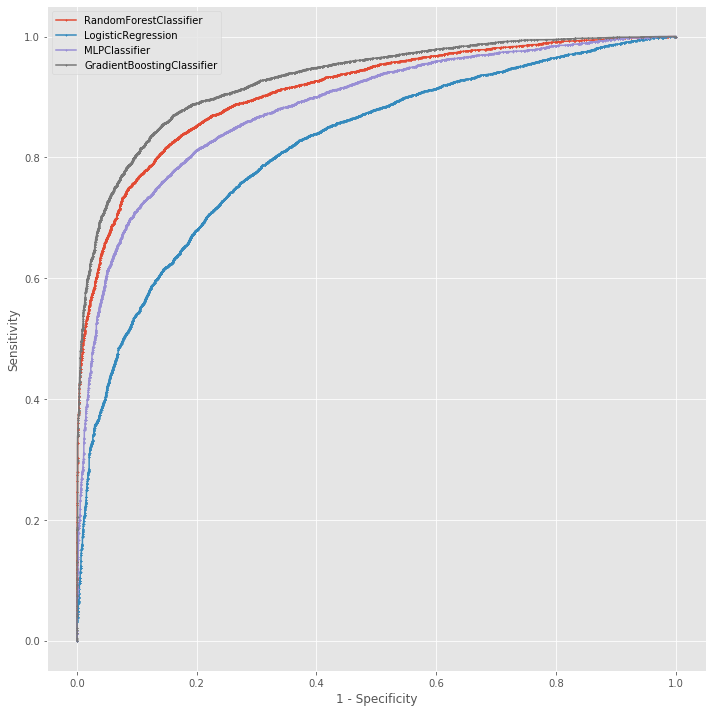

In [66]:
f_scores = []

plt.figure(figsize = (10, 10))
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
x = 0
for i in classifiers: #for each classifier
    
    label = {i}

    clf = i

    clf.fit(x_train, y_train) #fit it to train data

    y_pred = clf.predict(x_val) #predict using validation set
    y_score = clf.predict_proba(x_val) #ref: https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier

    score = f1_score(y_val, y_pred) #calculate f-1 score
    f_scores.append(score)

    fpr, tpr, thresholds = roc_curve(y_val, y_score[:,1])

    plt.plot(fpr, tpr, marker = '+', markersize = 2, label = label_list[x])
    x += 1
    
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [67]:
print(thresholds)

[1.99927805e+00 9.99278051e-01 9.98863949e-01 ... 2.34381833e-03
 2.08536583e-03 1.94275970e-03]


In [50]:
print(f_scores)

[0.8278655326042933, 0.7348500100664385, 0.8013178913738018, 0.8508409708933427]


# Calibration Curve

In [51]:
mlp_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), \
                        learning_rate = 'constant', solver = 'adam')

rf_clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


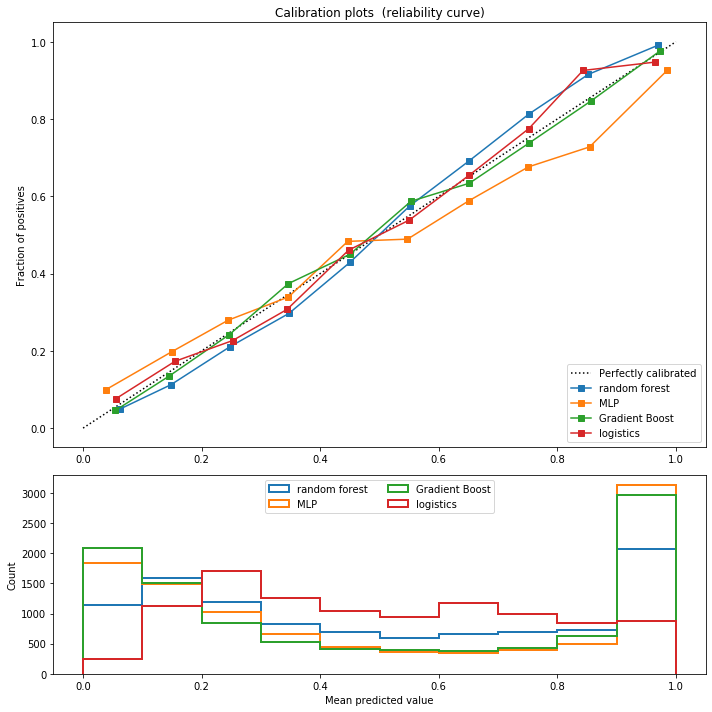

In [52]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(rf_clf, 'Random Forest'),
                  (mlp_clf, 'MLP'),
                  (GB_clf, "Gradient Boost"),
                  (log_clf, "Logistic")]:

    clf.fit(x_train, y_train)
    if hasattr(clf, "predict_proba"): #if the classifier can output probabalistic classes
        prob_pos = clf.predict_proba(x_val)[:, 1]
    else:  # use decision function. 
        prob_pos = clf.decision_function(x_val)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min()) #Rescaling data to have values between 0 and 1.
    
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_val, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Decision_function vs predict vs predict_proba

Reference: https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun

# tuning the classifier for recall with cross validation

In [53]:
# nexet two sections are from this article: 
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [54]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, \
recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [55]:
clf = GradientBoostingClassifier()

param_grid = {
    'max_depth': [12, 15],
    'max_features': ["sqrt"],
    'min_samples_leaf': [7 , 15, 25],
    'min_samples_split': [50 , 100],
    'n_estimators': [70, 90]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [56]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, verbose = 3)
    grid_search.fit(x_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(x_val.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of gradient boost optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [57]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
print("\n recall score =",recall_score(y_val, y_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.6min finished


Best params for recall_score
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 50, 'n_estimators': 90}

Confusion matrix of gradient boost optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      4491       590
pos       887      4228

 recall score = 0.8258064516129032


In [58]:
GB_clf = GradientBoostingClassifier(max_depth = 15, max_features = 'sqrt', min_samples_leaf = 7, \
                                    min_samples_split = 50, n_estimators = 90)
GB_clf.fit(x_train, y_train)
y_pred = GB_clf.predict(x_val)

print('Confusion matrix of gradient boost not optimized for recall score on the test data:')
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
print("\n recall score =",recall_score(y_val, y_pred))

Confusion matrix of gradient boost not optimized for recall score on the test data:
     pred_neg  pred_pos
neg      4485       596
pos       873      4242

 recall score = 0.829325513196481


# Adjust the decision threshold to identify the operating point

In [59]:
y_scores = grid_search_clf.predict_proba(x_val)[:, 1]

p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [60]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    print("\n recall score =",recall_score(y_val, y_pred_adj))
    print("f1 score =", f1_score(y_val, y_pred_adj))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg      1997      3084
pos        96      5019

 recall score = 0.9812316715542522
f1 score = 0.7594189741261915


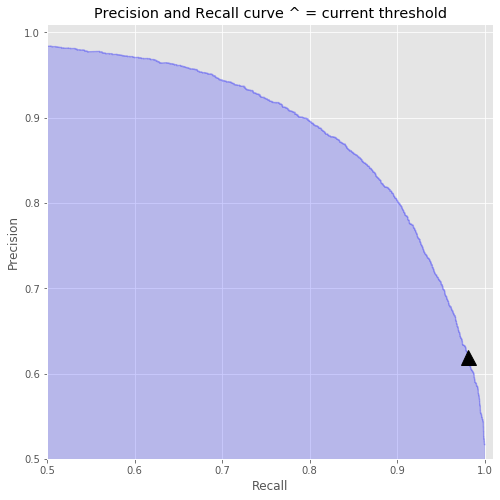

In [61]:
# want to minimize false negatives. can allow more false positives in exchange.
precision_recall_threshold(p, r, thresholds, 0.1)

In [62]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

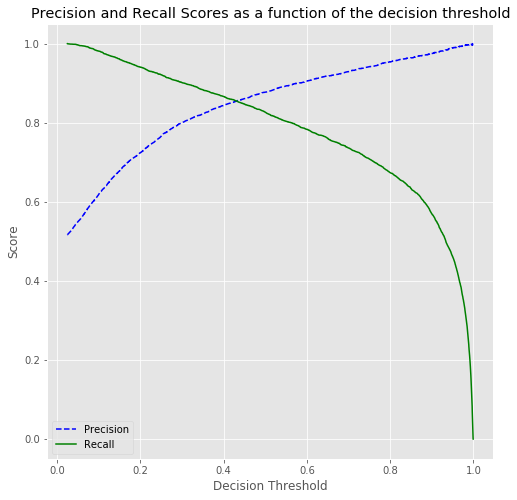

In [63]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [64]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9298927655461484


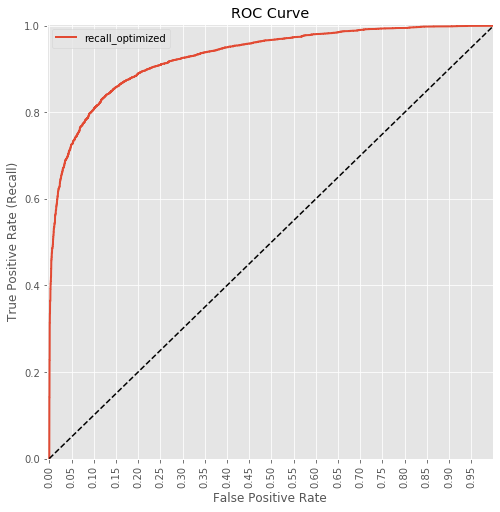

In [65]:
fpr, tpr, auc_thresholds = roc_curve(y_val, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')